In [17]:
## Loading libraries

import pandas as pd
import numpy as np
import numpy.random as nr
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
from sklearn import feature_selection as fs
import sklearn.decomposition as skde
import sklearn.metrics as sklm
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.stats as ss
from sklearn.linear_model import ElasticNet, Lasso,  Ridge, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from dataprep.eda import create_report
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import featurewiz as FW
%matplotlib inline

In [18]:
df1 = pd.read_csv("../Data files/train_labels.csv")
df2 = pd.read_csv("../Data files/train_values_wJZrCmI.csv")

In [19]:
df = df2.merge(df1, on='row_id')

In [20]:
## Dropping Row ID as it is a repeated column
df = df.drop_duplicates(keep = 'last')
df = df.drop_duplicates(subset = 'row_id', keep = 'last')

df.head()

,row_id,country,is_urban,age,female,married,religion,relationship_to_hh_head,education_level,literacy,...,financially_included,active_bank_user,active_mm_user,active_formal_nbfi_user,active_informal_nbfi_user,nonreg_active_mm_user,num_formal_institutions_last_year,num_informal_institutions_last_year,num_financial_activities_last_year,poverty_probability
0,0,C,False,18.0,True,True,P,Other,1.0,True,...,True,True,False,False,False,False,1,0,1,0.515
1,1,C,True,30.0,True,True,P,Other,1.0,True,...,True,True,False,False,False,False,1,0,0,0.981
2,2,A,False,20.0,True,True,Q,Spouse,1.0,True,...,False,False,False,False,False,False,0,0,0,0.982
3,3,A,False,61.0,False,True,Q,Head,0.0,False,...,False,False,False,False,False,False,0,0,0,0.879
4,4,D,False,26.0,True,True,X,Spouse,1.0,True,...,False,False,False,False,False,False,1,0,3,0.796


In [ ]:
df.duplicated().sum()

In [ ]:
df.isna().sum()

In [21]:
# Dropping cells with missing values
df.drop('bank_interest_rate', axis = 1, inplace = True)
df.drop('mm_interest_rate', axis = 1, inplace = True)
df.drop('mfi_interest_rate', axis = 1, inplace = True)
df.drop('other_fsp_interest_rate', axis = 1, inplace = True)
df.drop('row_id', axis = 1, inplace = True)

In [22]:
# Fixing columns with less missing values
df['education_level'].fillna(1.316241, inplace=True)
df['share_hh_income_provided'].fillna(2.888166, inplace=True)

In [23]:
## Removing outliers
df = df[df.poverty_probability > 0]
df = df[df.poverty_probability < 1]

In [ ]:
df.isna().sum()

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Correlation Limit = 0.7
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Regression problem ####
    Loaded train data. Shape = (12404, 55)
#### Single_Label Regression problem ####
No test data filename given...
Classifying features using a random sample of 10000 rows from dataset...
#### Single_Label Regression problem ####
    loading a sequential sample of 10000 rows into pandas for EDA
#######################################################################################
######################## C L A S S I F Y 

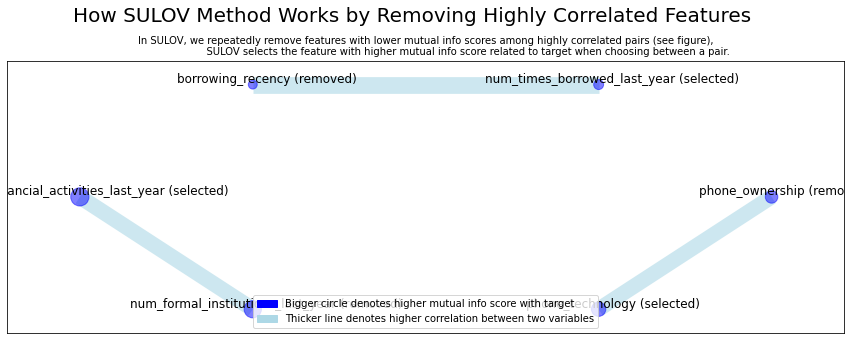

Time taken for SULOV method = 1 seconds
    Adding 42 categorical variables to reduced numeric variables  of 9
Finally 51 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
    there were no mixed data types or object columns that errored. Data is all numeric...
Shape of train data after adding missing values flags = (12404, 52)
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 51 
    Taking top 8 features per iteration...
    XGBoost version using 1.7.1 as tree method: hist
Number of booster rounds = 100
        using 51 variables...
            selecting 2 features in this iteration
            Time taken for regular XGBoost feature selection = 1 seconds

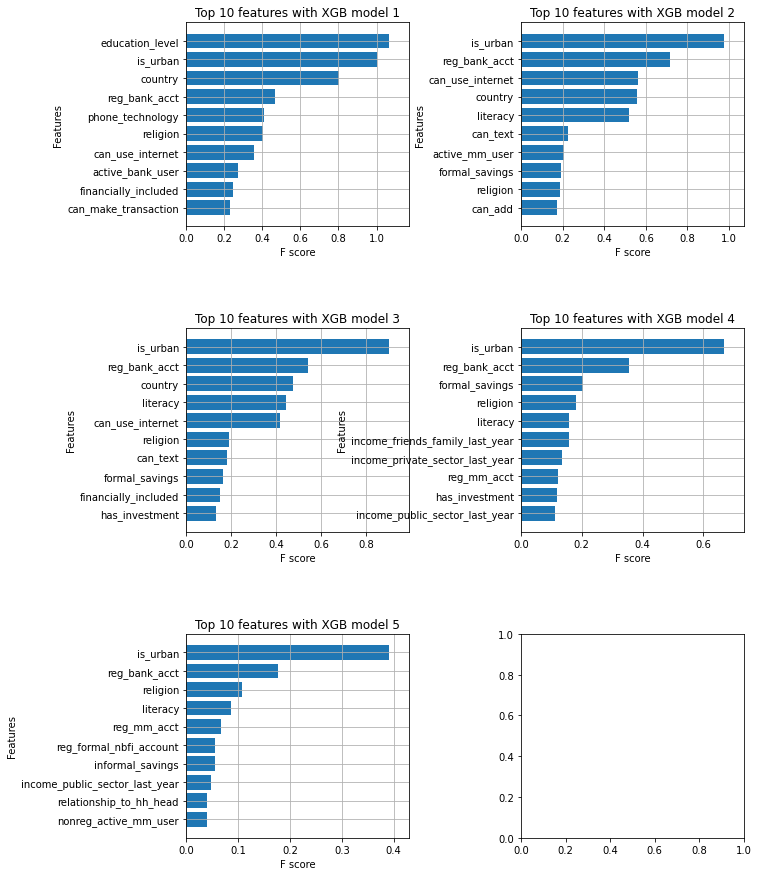

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 2 important features:
['education_level', 'is_urban']
Total Time taken for featurewiz selection = 3 seconds
Output contains a list of 2 important features and a train dataframe


In [15]:
outputs = FW.featurewiz(dataname= df, target='poverty_probability', corr_limit=0.70, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None)

## CAT feature analysis

In [24]:
df["poverty_probability"] = 100 * df["poverty_probability"]

In [25]:
## Making our target variable categorical
def create_pov_group(y):
    age_conditions = [
    (y['poverty_probability'] < 40 ),
    (y['poverty_probability'] >= 40) & (y['poverty_probability'] < 60),
    (y['poverty_probability'] >= 60) & (y['poverty_probability'] < 90),
    (y['poverty_probability'] >= 90)
    ]
    pov_choices = ['Under 40', '40 to 59', '60 to 89', '90 or Over']
    y['poverty_probability'] = np.select(age_conditions, pov_choices)

create_pov_group(df)

In [26]:
## Replacing Booleans with Numerical variables
def replace_boolean(data):
    for col in data:
        data[col].replace(True, 1, inplace=True)
        data[col].replace(False, 0, inplace=True)
        
replace_boolean(df)
df.dtypes

country                                   object
is_urban                                   int64
age                                      float64
female                                     int64
married                                    int64
religion                                  object
relationship_to_hh_head                   object
education_level                          float64
literacy                                   int64
can_add                                    int64
can_divide                                 int64
can_calc_percents                          int64
can_calc_compounding                       int64
employed_last_year                         int64
employment_category_last_year             object
employment_type_last_year                 object
share_hh_income_provided                 float64
income_ag_livestock_last_year              int64
income_friends_family_last_year            int64
income_government_last_year                int64
income_own_business_

In [ ]:
df.columns

In [ ]:
df['poverty_probability'].value_counts()

In [27]:
# Encoding the categorical value of poverty_probability 
df['poverty_probability'] = df['poverty_probability'].replace({'Under 40': 0, '40 to 59': 1, '60 to 89': 2, '90 or Over': 3})

In [ ]:
#Data distribtions for each class 
categorical_list = ["poverty_probability"]
df_categoric = df.loc[:, categorical_list]
for i in categorical_list:
    plt.figure()
    sns.countplot(x = i, data = df_categoric,hue = "poverty_probability")
    plt.title('Data distribtions')

In [28]:
# Dropping unneccesary categorical columns
df.drop("religion", axis=1, inplace = True)
df.drop("relationship_to_hh_head", axis=1, inplace = True)
df.drop("country", axis=1, inplace = True)
df.drop("employment_category_last_year", axis=1, inplace = True)
df.drop("employment_type_last_year", axis=1, inplace = True)


# NUM

In [ ]:
numeric_list = ['is_urban', 'age', 'female', 'married', 'education_level', 'literacy',
       'can_add', 'can_divide', 'can_calc_percents', 'can_calc_compounding',
       'employed_last_year', 'share_hh_income_provided',
       'income_ag_livestock_last_year', 'income_friends_family_last_year',
       'income_government_last_year', 'income_own_business_last_year',
       'income_private_sector_last_year', 'income_public_sector_last_year',
       'num_times_borrowed_last_year', 'borrowing_recency', 'formal_savings',
       'informal_savings', 'cash_property_savings', 'has_insurance',
       'has_investment', 'num_shocks_last_year',
       'avg_shock_strength_last_year', 'borrowed_for_emergency_last_year',
       'borrowed_for_daily_expenses_last_year',
       'borrowed_for_home_or_biz_last_year', 'phone_technology', 'can_call',
       'can_text', 'can_use_internet', 'can_make_transaction',
       'phone_ownership', 'advanced_phone_use', 'reg_bank_acct', 'reg_mm_acct',
       'reg_formal_nbfi_account', 'financially_included', 'active_bank_user',
       'active_mm_user', 'active_formal_nbfi_user',
       'active_informal_nbfi_user', 'nonreg_active_mm_user',
       'num_formal_institutions_last_year',
       'num_informal_institutions_last_year',
       'num_financial_activities_last_year', 'poverty_probability']
df_numeric = df.loc[:, numeric_list]
df_numeric.head()

In [ ]:
df.dtypes

In [29]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [30]:
# split the class from other features
y = df["poverty_probability"]
x = df.drop("poverty_probability", axis=1)

In [31]:
# Applying SMOTE
smote = SMOTE(random_state=10)
print('Original dataset shape %s' % Counter(y))
x, y = smote.fit_resample(x, y)
print('Resampled dataset shape %s' % Counter(y))

Original dataset shape Counter({2: 4600, 0: 3036, 3: 2517, 1: 2251})
Resampled dataset shape Counter({1: 4600, 3: 4600, 2: 4600, 0: 4600})


In [ ]:
x.shape

In [32]:
# concatenate the features
df_1=pd.concat([x,y],axis=1)

In [ ]:
df_1.shape

In [ ]:
categorical_list = ["age_group"]
df_categoric = df_1.loc[:, categorical_list]
for i in categorical_list:
    plt.figure()
    sns.countplot(x = i, data = df_categoric,hue = "age_group")
    plt.title('Data distribtions')

In [ ]:
df.columns

# Splitting the dataset

In [33]:
df.head()

,is_urban,age,female,married,education_level,literacy,can_add,can_divide,can_calc_percents,can_calc_compounding,...,financially_included,active_bank_user,active_mm_user,active_formal_nbfi_user,active_informal_nbfi_user,nonreg_active_mm_user,num_formal_institutions_last_year,num_informal_institutions_last_year,num_financial_activities_last_year,poverty_probability
0,0,18.0,1,1,1.0,1,1,1,1,1,...,1,1,0,0,0,0,1,0,1,1
1,1,30.0,1,1,1.0,1,1,1,0,0,...,1,1,0,0,0,0,1,0,0,3
2,0,20.0,1,1,1.0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,3
3,0,61.0,0,1,0.0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,2
4,0,26.0,1,1,1.0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,3,2


In [34]:
x = df_1.drop(['poverty_probability'], axis=1)
y = df_1['poverty_probability']
x_train , x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2022)

In [35]:
from sklearn.preprocessing import StandardScaler

In [36]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

# ML

## KNN

In [37]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
knn_predictions = knn.predict(x_test)

In [38]:
print(accuracy_score(y_test, knn_predictions))

0.4923913043478261


In [39]:
print(classification_report(y_test, knn_predictions))

              precision    recall  f1-score   support

           0       0.50      0.64      0.56       926
           1       0.47      0.51      0.49       943
           2       0.45      0.29      0.35       920
           3       0.54      0.52      0.53       891

    accuracy                           0.49      3680
   macro avg       0.49      0.49      0.48      3680
weighted avg       0.49      0.49      0.48      3680



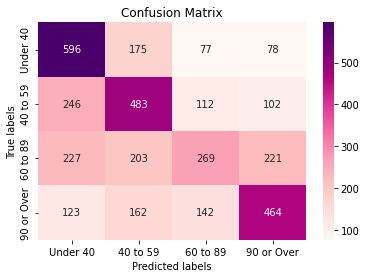

In [40]:
#Creating a confusion matrix to visualize classification results.
cm = confusion_matrix(y_test,knn_predictions)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g',cmap= 'RdPu', ax=ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Under 40', '40 to 59', '60 to 89', '90 or Over']); ax.yaxis.set_ticklabels(['Under 40', '40 to 59', '60 to 89', '90 or Over']);

## Decision Tree

In [49]:
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
dtc_predictions = dtc.predict(x_test)

In [50]:
print(accuracy_score(y_test, dtc_predictions))

0.46494565217391304


In [51]:
print(classification_report(y_test, dtc_predictions))

              precision    recall  f1-score   support

           0       0.47      0.50      0.49       926
           1       0.47      0.48      0.47       943
           2       0.40      0.39      0.40       920
           3       0.51      0.50      0.50       891

    accuracy                           0.46      3680
   macro avg       0.47      0.47      0.46      3680
weighted avg       0.46      0.46      0.46      3680



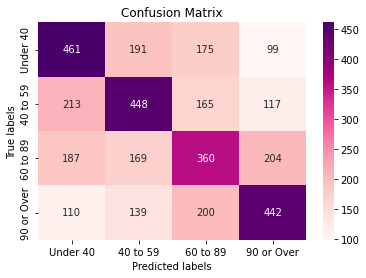

In [52]:
#Creating a confusion matrix to visualize classification results.
cm = confusion_matrix(y_test,dtc_predictions)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', cmap= 'RdPu', ax=ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Under 40', '40 to 59', '60 to 89', '90 or Over']); ax.yaxis.set_ticklabels(['Under 40', '40 to 59', '60 to 89', '90 or Over']);

# Gridsearch

In [41]:
from sklearn.model_selection import GridSearchCV

In [42]:
k_range = list(range(1,31))
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)

knng = KNeighborsClassifier()

grid = GridSearchCV(knng, param_grid, cv = 10, scoring = 'accuracy')
grid.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [43]:
grid.best_score_

0.5319972826086956

In [44]:
grid.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

In [45]:
grid.best_estimator_

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [46]:
y_pred = grid.predict(x_test)

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.61      0.58       926
           1       0.53      0.56      0.54       943
           2       0.44      0.32      0.37       920
           3       0.56      0.63      0.59       891

    accuracy                           0.53      3680
   macro avg       0.52      0.53      0.52      3680
weighted avg       0.52      0.53      0.52      3680



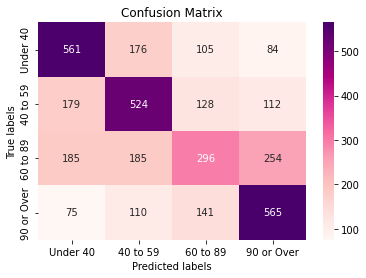

In [48]:
#Creating a confusion matrix to visualize classification results.
cm = confusion_matrix(y_test,y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', cmap= 'RdPu', ax=ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Under 40', '40 to 59', '60 to 89', '90 or Over']); ax.yaxis.set_ticklabels(['Under 40', '40 to 59', '60 to 89', '90 or Over']);

## Grid for decision tree

In [53]:
param_grid_ = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
              }

In [54]:
dtcg = DecisionTreeClassifier()
grid_search = GridSearchCV(dtcg, param_grid=param_grid_, cv=10, verbose=True)

In [55]:
grid_search.fit(x_train, y_train)

Fitting 10 folds for each of 90 candidates, totalling 900 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt', 'log2']},
             verbose=True)

In [56]:
grid_search.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=9,
                       max_features='sqrt')

In [57]:
grid_search.best_score_

0.4110733695652174

In [58]:
y_pred_ = grid.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred_))

In [ ]:
#Creating a confusion matrix to visualize classification results.
cm = confusion_matrix(y_test,y_pred_)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', cmap= 'RdPu', ax=ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Under 40', '40 to 59', '60 to 89', '90 or Over']); ax.yaxis.set_ticklabels(['Under 40', '40 to 59', '60 to 89', '90 or Over']);

## Random Forest

In [59]:
ranforest = RandomForestClassifier(random_state=42)
ranforest.fit(x_train, y_train)
rdf_predictions = ranforest.predict(x_test)
# evaluates the model
#ranforest.score(x_test,y_test)*100
print(accuracy_score(y_test, rdf_predictions))

0.6089673913043478


In [60]:
print(classification_report(y_test, rdf_predictions))

              precision    recall  f1-score   support

           0       0.61      0.70      0.65       926
           1       0.69      0.58      0.63       943
           2       0.50      0.50      0.50       920
           3       0.65      0.66      0.65       891

    accuracy                           0.61      3680
   macro avg       0.61      0.61      0.61      3680
weighted avg       0.61      0.61      0.61      3680



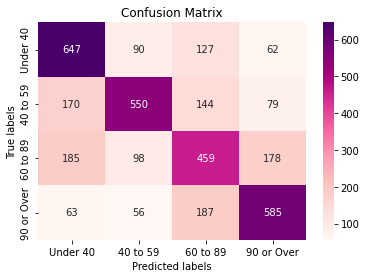

In [61]:
#Creating a confusion matrix to visualize classification results.
cm = confusion_matrix(y_test,rdf_predictions)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', cmap= 'RdPu', ax=ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Under 40', '40 to 59', '60 to 89', '90 or Over']); ax.yaxis.set_ticklabels(['Under 40', '40 to 59', '60 to 89', '90 or Over']);

## Grid search for random forest

In [62]:
f_range = list(range(1,31))
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)

knng = KNeighborsClassifier()

grid = GridSearchCV(knng, param_grid, cv = 10, scoring = 'accuracy')
grid.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [63]:
grid_search.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=9,
                       max_features='sqrt')

In [64]:
grid_search.best_score_

0.4110733695652174